### CHARGEMENT DES OBSERVATIONS

In [1]:
import pandas as pd
from tensorflow.python.ops.gen_data_flow_ops import tensor_array
sonar = pd.read_csv("sonar.all-data.csv", header = None)
sonar.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


### PREPARATION DES DONNEES

In [2]:
print("Nbr colonnes: ", len(sonar.columns))
#On ne prend que les données issues du sonar pour l'apprentissage
X = sonar[range(60)].values

Nbr colonnes:  61


In [3]:
#On ne prend que les libellé
y = sonar[60].values

In [4]:
#On encode : Les mines sont égales à 0 et les rochers égaux à 1
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [5]:
#On ajoute un encodage pour créer des classes :
# Si c'est une mine [1,0]
# Si c'est un rocher [0,1]
import numpy as np
n_labels = len(y)
n_unique_labels = len(np.unique(y))
one_hot_encode = np.zeros((n_labels, n_unique_labels))
one_hot_encode[np.arange(n_labels), y] = 1
Y = one_hot_encode

In [6]:
#Verification en prenant les enregistrement 0 et 97
print("Classe Rocher:",int(Y[0][1]))
print("Classe Mine :",int(Y[97][1]))

Classe Rocher: 1
Classe Mine : 0


### CREATION DES JEUX D'APPRENTISSAGE ET DE TEST

In [7]:
#On mélange
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=1)

In [8]:
#Creation des jeux d'apprentissage
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.07, random_state=42)

### PARAMETRAGE DU RESEAU DE  NEURONES

In [9]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from random import seed
seed = 42

epochs = 300
nombre_neurones_entree = 60
nombre_neurones_sortie = 2
taux_apprentissage = 0.02

#Variable TensorFLow correspondant aux 60 valeurs des neurones d'entrée
tf_neurones_entrees_X = tf.placeholder(tf.float32,[None, 60])

#Variable TensorFlow correspondant au 2 neurones de sortie
tf_valeurs_reelles_Y = tf.placeholder(tf.float32,[None, 2])

Instructions for updating:
non-resource variables are not supported in the long term


### FONCTION POUR PERMETTRE LE CHANGEMENT DE NOMBRE DE NEURONNES

In [10]:
def Nombre_de_neuronnes(nb_neuronnes): 
    
    global poids
    poids = {
        # 60 neurones d'entrées vers 12 Neurones de la couche cachée
        'couche_entree_vers_cachee': tf.Variable(tf.random_uniform([60, nb_neuronnes], minval=-0.3, maxval=0.3), tf.float32),

        # 12 neurones de la couche cachée vers 2 de la couche de sortie
        'couche_cachee_vers_sortie': tf.Variable(tf.random_uniform([nb_neuronnes, 2], minval=-0.3, maxval=0.3), tf.float32),


    }
    
    global poids_biais
    poids_biais = {
         #1 biais de la couche d'entrée vers les 12 neurones de la couche cachée
        'poids_biais_couche_entree_vers_cachee': tf.Variable(tf.zeros([nb_neuronnes]), tf.float32),

        #1 biais de la couche cachée vers les 2 neurones de la couche de sortie
        'poids_biais_couche_cachee_vers_sortie': tf.Variable(tf.zeros([2]), tf.float32),
    }
    
#Nombre_de_neuronnes(12)
Nombre_de_neuronnes(24)
#Nombre_de_neuronnes(26)
#Nombre_de_neuronnes(35)

### FONCTION DE  CREATION DU RESEAU DE NEURONES

In [11]:
def reseau_neurones_multicouches(sonar_en_entrees, poids, poids_biais):

    #Calcul de l'activation de la première couche
    premiere_activation = tf.sigmoid(tf.matmul(tf_neurones_entrees_X, poids['couche_entree_vers_cachee']) + poids_biais['poids_biais_couche_entree_vers_cachee'])

    #Calcul de l'activation de la seconde couche
    activation_couche_cachee = tf.sigmoid(tf.matmul(premiere_activation, poids['couche_cachee_vers_sortie']) + poids_biais['poids_biais_couche_cachee_vers_sortie'])

    return activation_couche_cachee

### CREATION DU RESEAU DE NEURONES

In [12]:
reseau = reseau_neurones_multicouches(tf_neurones_entrees_X, poids, poids_biais)

### ERREUR ET OPTIMISATION

In [13]:
#Fonction d'erreur de moyenne quadratique MSE
fonction_erreur = tf.reduce_sum(tf.pow(tf_valeurs_reelles_Y-reseau,2))

#Fonction de precision
fonction_precision = tf.metrics.accuracy(labels=tf_valeurs_reelles_Y,predictions=reseau)


#Descente de gradient avec un taux d'apprentissage fixé à 0.1
optimiseur = tf.train.GradientDescentOptimizer(learning_rate=taux_apprentissage).minimize(fonction_erreur)


### APPRENTISSAGE

In [14]:
#Initialisation des variable
init = tf.global_variables_initializer()

#Demarrage d'une session d'apprentissage
session = tf.Session()
session.run(init)

#Pour la réalisation du graphique pour la MSE
Graphique_MSE=[]

In [15]:
#Pour chaque epoch
for i in range(epochs):

   #Realisation de l'apprentissage avec mise à jour des poids
   session.run(optimiseur, feed_dict = {tf_neurones_entrees_X: train_x, tf_valeurs_reelles_Y:train_y})

   #Calculer l'erreur d'apprentissage
   MSE = session.run(fonction_erreur, feed_dict = {tf_neurones_entrees_X: train_x, tf_valeurs_reelles_Y:train_y})

   #Affichage des informations
   Graphique_MSE.append(MSE)
   print("EPOCH (" + str(i) + "/" + str(epochs) + ") -  MSE: "+ str(MSE))


EPOCH (0/300) -  MSE: 97.44806
EPOCH (1/300) -  MSE: 96.46345
EPOCH (2/300) -  MSE: 96.031044
EPOCH (3/300) -  MSE: 95.70285
EPOCH (4/300) -  MSE: 95.470894
EPOCH (5/300) -  MSE: 95.26556
EPOCH (6/300) -  MSE: 95.074295
EPOCH (7/300) -  MSE: 94.8806
EPOCH (8/300) -  MSE: 94.67763
EPOCH (9/300) -  MSE: 94.45949
EPOCH (10/300) -  MSE: 94.22182
EPOCH (11/300) -  MSE: 93.96115
EPOCH (12/300) -  MSE: 93.673935
EPOCH (13/300) -  MSE: 93.35729
EPOCH (14/300) -  MSE: 93.00789
EPOCH (15/300) -  MSE: 92.62311
EPOCH (16/300) -  MSE: 92.19996
EPOCH (17/300) -  MSE: 91.73635
EPOCH (18/300) -  MSE: 91.23014
EPOCH (19/300) -  MSE: 90.68085
EPOCH (20/300) -  MSE: 90.0891
EPOCH (21/300) -  MSE: 89.46055
EPOCH (22/300) -  MSE: 88.80944
EPOCH (23/300) -  MSE: 88.180984
EPOCH (24/300) -  MSE: 87.69434
EPOCH (25/300) -  MSE: 87.77098
EPOCH (26/300) -  MSE: 89.40425
EPOCH (27/300) -  MSE: 95.70411
EPOCH (28/300) -  MSE: 102.35336
EPOCH (29/300) -  MSE: 110.115425
EPOCH (30/300) -  MSE: 93.31348
EPOCH (31/30

EPOCH (251/300) -  MSE: 55.356133
EPOCH (252/300) -  MSE: 52.178406
EPOCH (253/300) -  MSE: 55.21411
EPOCH (254/300) -  MSE: 52.02231
EPOCH (255/300) -  MSE: 55.072727
EPOCH (256/300) -  MSE: 51.866722
EPOCH (257/300) -  MSE: 54.931942
EPOCH (258/300) -  MSE: 51.711624
EPOCH (259/300) -  MSE: 54.791718
EPOCH (260/300) -  MSE: 51.55693
EPOCH (261/300) -  MSE: 54.651997
EPOCH (262/300) -  MSE: 51.402607
EPOCH (263/300) -  MSE: 54.51274
EPOCH (264/300) -  MSE: 51.248634
EPOCH (265/300) -  MSE: 54.37387
EPOCH (266/300) -  MSE: 51.094936
EPOCH (267/300) -  MSE: 54.235405
EPOCH (268/300) -  MSE: 50.941483
EPOCH (269/300) -  MSE: 54.09723
EPOCH (270/300) -  MSE: 50.788246
EPOCH (271/300) -  MSE: 53.959328
EPOCH (272/300) -  MSE: 50.63517
EPOCH (273/300) -  MSE: 53.821667
EPOCH (274/300) -  MSE: 50.482212
EPOCH (275/300) -  MSE: 53.684185
EPOCH (276/300) -  MSE: 50.329376
EPOCH (277/300) -  MSE: 53.546844
EPOCH (278/300) -  MSE: 50.17657
EPOCH (279/300) -  MSE: 53.409595
EPOCH (280/300) -  MSE

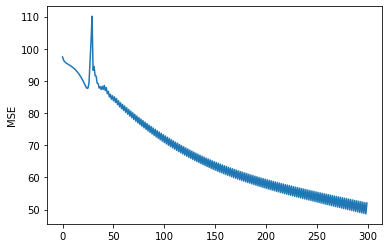

In [16]:
#Affichage graphique MSE
import matplotlib.pyplot as plt
plt.plot(Graphique_MSE)
plt.ylabel('MSE')
plt.show()

### VERIFICATION DE L'APPRENTISSAGE

In [17]:
#Les probabilités de chaque classe 'Mine' ou 'rocher' issues de l'apprentissage sont stockée dans le modèle.
#A l'aide de tf.argmax, on récupére les indexs des probabilités les plus elevées pour chaque sonar
#Ex: Si pour une observation nous avons [0.56, 0.89] renverra 1 car la valeur la plus élevée se trouve à l'index 1
#Ex : Si pour une observation nous avons [0.90, 0.34 ]  renverra 0 car la valeur la plus élevée se trouve à l'index 0
classifications = tf.argmax(reseau, 1)

#Dans le tableau des valeurs réelles :
#Les mines sont encodées comme suit [1,0] l'index ayant la plus grande valeur est 0
#Les rochers ont pour valeur [0,1] sl'index ayant la plus grande valeur est 1

#Si la classification est de [0.90, 0.34 ] l'index ayant la plus grande valeur est 0
#Si c'est une mine [1,0] l'index ayant la plus grande valeur est 0
#Si les deux index sont identiques alors on peut affirmer que c'est une bonne classification
formule_calcul_bonnes_classifications = tf.equal(classifications, tf.argmax(tf_valeurs_reelles_Y,1))


#La précision se calcul en faisant la moyenne (tf.mean)
# des bonnes classifications (aprés les avoir converties en décimale tf.cast, tf.float32)
formule_precision = tf.reduce_mean(tf.cast(formule_calcul_bonnes_classifications, tf.float32))

### PRECISION SUR LES DONNEES DE TESTS

In [18]:
nb_classifications = 0;
nb_bonnes_classifications = 0

#On parcours l'ensemble des données de test (text_x)
for i in range(0,test_x.shape[0]):

    #On récupere les informations
    donneesSonar = test_x[i].reshape(1,60)
    classificationAttendue = test_y[i].reshape(1,2)

    # On réalise la classification
    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X:donneesSonar})

    #On calcule la précision de la classification à l'aide de la formule établie auparavant
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X:donneesSonar, tf_valeurs_reelles_Y:classificationAttendue})


    #On affiche pour observation la classe originale et la classification réalisée
    print(i,"Classe attendue: ", int(session.run(tf_valeurs_reelles_Y[i][1],feed_dict={tf_valeurs_reelles_Y:test_y})), " Classification: ", prediction_run[0] )

    nb_classifications = nb_classifications+1
    if(accuracy_run*100 ==100):
        nb_bonnes_classifications = nb_bonnes_classifications+1


print("-------------")
print("Précision sur les donnees de tests = "+str((nb_bonnes_classifications/nb_classifications)*100)+"%")


0 Classe attendue:  1  Classification:  1
1 Classe attendue:  0  Classification:  0
2 Classe attendue:  1  Classification:  0
3 Classe attendue:  1  Classification:  1
4 Classe attendue:  0  Classification:  0
5 Classe attendue:  1  Classification:  1
6 Classe attendue:  0  Classification:  0
7 Classe attendue:  1  Classification:  1
8 Classe attendue:  1  Classification:  0
9 Classe attendue:  0  Classification:  0
10 Classe attendue:  0  Classification:  0
11 Classe attendue:  0  Classification:  0
12 Classe attendue:  0  Classification:  0
13 Classe attendue:  1  Classification:  0
14 Classe attendue:  0  Classification:  0
-------------
Précision sur les donnees de tests = 80.0%


### PRECISION SUR LES DONNEES D'APPRENTISSAGE

In [19]:
nb_classifications = 0;
nb_bonnes_classifications = 0
for i in range(0,train_x.shape[0]):

    # On récupere les informations
    donneesSonar = train_x[i].reshape(1, 60)
    classificationAttendue = train_y[i].reshape(1, 2)

    # On réalise la classification
    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X: donneesSonar})

    # On calcule la précision de la classification à l'aide de la formule établie auparavant
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X: donneesSonar, tf_valeurs_reelles_Y: classificationAttendue})

    nb_classifications = nb_classifications + 1
    if (accuracy_run * 100 == 100):
        nb_bonnes_classifications = nb_bonnes_classifications + 1


print("Précision sur les donnees d'apprentissage = " + str((nb_bonnes_classifications / nb_classifications) * 100) + "%")

Précision sur les donnees d'apprentissage = 79.79274611398964%


### PRECISION SUR L'ENSEMBLE DES DONNEES

In [20]:
nb_classifications = 0;
nb_bonnes_classifications = 0
for i in range(0,207):

    prediction_run = session.run(classifications, feed_dict={tf_neurones_entrees_X:X[i].reshape(1,60)})
    accuracy_run = session.run(formule_precision, feed_dict={tf_neurones_entrees_X:X[i].reshape(1,60), tf_valeurs_reelles_Y:Y[i].reshape(1,2)})

    nb_classifications = nb_classifications + 1
    if (accuracy_run * 100 == 100):
        nb_bonnes_classifications = nb_bonnes_classifications + 1


print("Précision sur l'ensemble des données = " + str((nb_bonnes_classifications / nb_classifications) * 100) + "%")




session.close()

Précision sur l'ensemble des données = 79.71014492753623%
